<a href="https://colab.research.google.com/github/sivaprasadt246/Automatic_Ticket_Classification_Assignment/blob/main/Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [54]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

In [56]:
import en_core_web_sm
nlp = en_core_web_sm.load()

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [57]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

# Opening JSON file 
root_path = "/content/gdrive/MyDrive/NLP_Assignment/complaints-2021-05-14_08_16.json"
#root_path = 'complaints-2021-05-14_08_16.json'
f = open(root_path)
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data preparation

In [58]:
# Inspect the dataframe to understand the given data.
df.head(10)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A
5,complaint-public-v2,complaint,3275312,0.0,Older American,48227,3275312,Managing an account,2019-06-13T12:00:00-05:00,MI,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-14T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
6,complaint-public-v2,complaint,3238804,0.0,None,76262,3238804,Managing an account,2019-05-10T12:00:00-05:00,TX,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Phone,2019-05-10T12:00:00-05:00,None,Checking account,Yes,,Problem using a debit or ATM card,N/A
7,complaint-public-v2,complaint,3249272,0.0,None,07753,3249272,Trouble during payment process,2019-05-15T12:00:00-05:00,NJ,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-05-21T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,N/A
8,complaint-public-v2,complaint,3351653,0.0,None,60621,3351653,Closing an account,2019-08-22T12:00:00-05:00,IL,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-08-23T12:00:00-05:00,None,Checking account,Yes,,Company closed your account,N/A
9,complaint-public-v2,complaint,3273612,0.0,None,99354,3273612,Managing an account,2019-06-11T12:00:00-05:00,WA,...,Closed with monetary relief,JPMORGAN CHASE & CO.,Referral,2019-06-17T12:00:00-05:00,None,Checking account,Yes,,Cashing a check,N/A


In [59]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [60]:
#Assign new column names
#renaming the column names for better readability

df = df[['_source.complaint_what_happened','_source.product','_source.sub_product',]]

df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})
df.head()

,complaint_text,category,sub_category
0,,Debt collection,Credit card debt
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
3,,Mortgage,Conventional home mortgage
4,,Credit card or prepaid card,General-purpose credit card or charge card


In [61]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_text']==''] = np.nan
df.complaint_text.isnull().sum()

57241

In [62]:
#Remove all rows where complaints column is nan
df = df[~df['complaint_text'].isnull()]
df.complaint_text.isnull().sum()

0

In [63]:
df.head (5)

,complaint_text,category,sub_category
1,Good morning my name is XXXX XXXX and I apprec...,Debt collection,Credit card debt
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Credit card or prepaid card,General-purpose credit card or charge card
10,Chase Card was reported on XX/XX/2019. However...,"Credit reporting, credit repair services, or o...",Other personal consumer report
11,"On XX/XX/2018, while trying to book a XXXX XX...","Credit reporting, credit repair services, or o...",Credit reporting
14,my grand son give me check for {$1600.00} i de...,Checking or savings account,Checking account


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [64]:
# Write your function here to clean the text and remove all the unnecessary elements.
def clean_text(text):
    text = text.lower()  # Make the text lowercase
    text = re.sub('\[.*\]','', text).strip() # Remove text in square brackets
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = re.sub('\S*\d\S*\s*','', text).strip()  # Remove words containing numbers
    return text.strip()

In [65]:
df.complaint_text.head()

1     Good morning my name is XXXX XXXX and I apprec...
2     I upgraded my XXXX XXXX card in XX/XX/2018 and...
10    Chase Card was reported on XX/XX/2019. However...
11    On XX/XX/2018, while trying to book a XXXX  XX...
14    my grand son give me check for {$1600.00} i de...
Name: complaint_text, dtype: object

In [66]:
df.complaint_text = df.complaint_text.apply(lambda x: clean_text(x))
df.complaint_text.head()

1     good morning my name is xxxx xxxx and i apprec...
2     i upgraded my xxxx xxxx card in and was told b...
10    chase card was reported on however fraudulent ...
11    on while trying to book a xxxx  xxxx  ticket i...
14    my grand son give me check for i deposit it in...
Name: complaint_text, dtype: object

In [67]:
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [68]:
#nlp = en_core_web_sm.load(disable = ['ner', 'parser'])
#print(nlp.pipe_names)

In [69]:
#Write your function to Lemmatize the texts
stopwords = nlp.Defaults.stop_words

def lemmatizer(text):
    doc = nlp(text)
    lemmatized_output = ' '.join([token.lemma_ for token in doc if not token.text in set(stopwords)])
    return lemmatized_output

In [70]:
df['lemmatized_complaint'] =  df.complaint_text.apply(lambda x: lemmatizer(x))
df.head(5)

,complaint_text,category,sub_category,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,Debt collection,Credit card debt,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,Credit card or prepaid card,General-purpose credit card or charge card,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,"Credit reporting, credit repair services, or o...",Other personal consumer report,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,"Credit reporting, credit repair services, or o...",Credit reporting,try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,Checking or savings account,Checking account,grand son check deposit chase account fund cle...


In [71]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint_text','lemmatized_complaint']]
df_clean.head()

,complaint_text,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...


In [72]:
#Write your function to extract the POS tags 
nlp = en_core_web_sm.load()

def extract_pos_tags(text):
    doc = nlp(text)
    tag_nn = [token.text for token in doc if token.tag_ == 'NN']
    return ' '.join(tag_nn)

df_clean["complaint_POS_removed"] = df_clean.lemmatized_complaint.apply(lambda x: extract_pos_tags(x))
df_clean.head()

<ipython-input-72-7cff4f3f4a6a>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...


In [73]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit chase credit card chase freedom problem...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




(array([4.188e+03, 5.257e+03, 3.790e+03, 2.565e+03, 1.588e+03, 1.044e+03,
        7.120e+02, 5.300e+02, 4.360e+02, 2.980e+02, 1.390e+02, 1.170e+02,
        7.600e+01, 5.600e+01, 3.800e+01, 3.200e+01, 2.900e+01, 2.500e+01,
        2.600e+01, 1.800e+01, 1.400e+01, 1.200e+01, 5.000e+00, 8.000e+00,
        1.000e+00, 5.000e+00, 9.000e+00, 3.000e+00, 1.000e+01, 2.000e+00,
        2.000e+00, 3.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 3.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

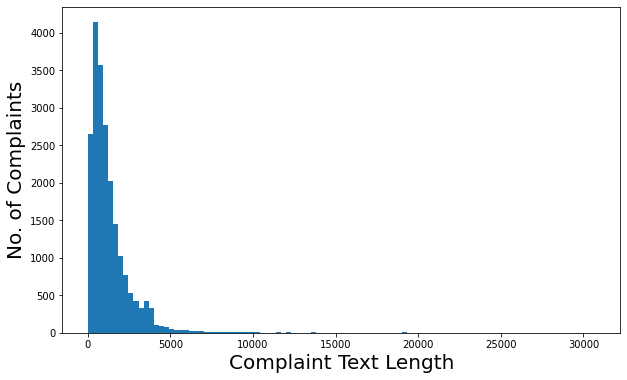

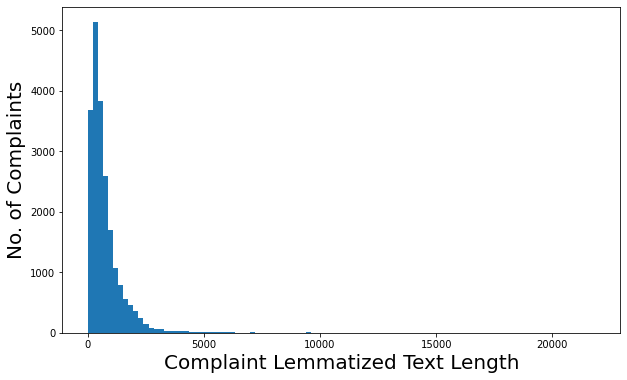

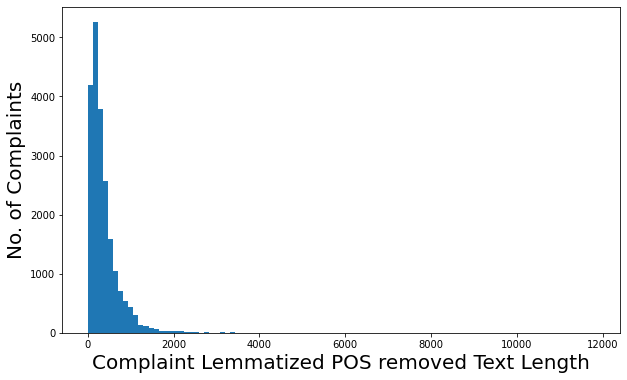

In [74]:
# Write your code here to visualise the data according to the 'Complaint' character length
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_text]

plt.xlabel('Complaint Text Length',size=20)
plt.ylabel('No. of Complaints',size=20)
plt.hist(doc_lens, bins = 100)

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.lemmatized_complaint]

plt.xlabel('Complaint Lemmatized Text Length',size=20)
plt.ylabel('No. of Complaints',size=20)
plt.hist(doc_lens, bins = 100)

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in df_clean.complaint_POS_removed]

plt.xlabel('Complaint Lemmatized POS removed Text Length',size=20)
plt.ylabel('No. of Complaints',size=20)
plt.hist(doc_lens, bins = 100)

In [75]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Find the top 40 words by frequency among all the articles after processing the text.

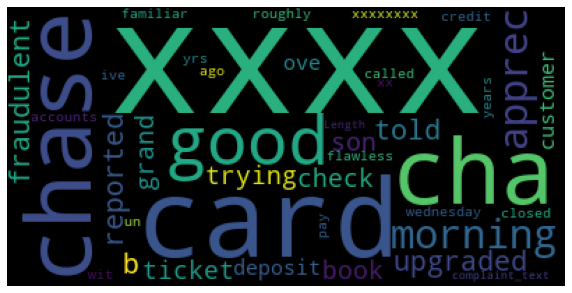

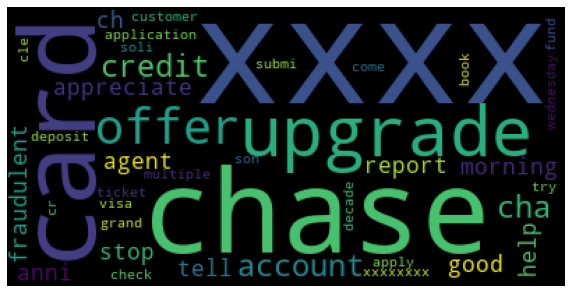

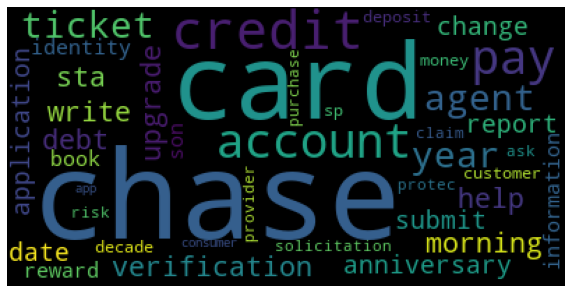

In [76]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_text))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.lemmatized_complaint))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

wordcloud = WordCloud(stopwords=stopwords,max_words=40).generate(str(df_clean.complaint_POS_removed))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [77]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...


In [78]:
# Top n bigram function

def get_top_n_bigram(text, ngram=1, top=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)

    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:top]

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [79]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_unigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=1, top=30)

In [80]:
#Print the top 10 words in the unigram frequency
print('Top 10 unigrams: ')
top_30_unigrams[:10]

Top 10 unigrams: 


[('chase', 55396),
 ('account', 39603),
 ('credit', 32425),
 ('card', 29043),
 ('payment', 20181),
 ('charge', 16501),
 ('time', 15214),
 ('money', 11665),
 ('day', 11643),
 ('bank', 11139)]

In [81]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_bigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=2, top=30)

In [82]:
#Print the top 10 words in the bigram frequency
print('Top 10 bigrams: ')
top_30_bigrams[:10]

Top 10 bigrams: 


[('credit card', 12171),
 ('credit report', 3618),
 ('chase credit', 3135),
 ('customer service', 2714),
 ('account chase', 2657),
 ('chase account', 2181),
 ('contact chase', 1931),
 ('debit card', 1909),
 ('account account', 1837),
 ('chase bank', 1770)]

In [83]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_30_trigrams = get_top_n_bigram(df_clean.Complaint_clean,ngram=3, top=30)

In [84]:
#Print the top 10 words in the trigram frequency
print('Top 10 trigrams: ')
top_30_trigrams[:10]

Top 10 trigrams: 


[('chase credit card', 2159),
 ('credit card account', 986),
 ('credit card company', 958),
 ('credit card chase', 815),
 ('chase customer service', 509),
 ('charge credit card', 495),
 ('inquiry credit report', 456),
 ('credit card credit', 454),
 ('account credit card', 358),
 ('credit card charge', 356)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [85]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [86]:
#All masked texts has been removed
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [87]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [88]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean.Complaint_clean) 

tfidf.get_feature_names()[:10]


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['aarp',
 'abate',
 'abatement',
 'abbreviation',
 'abet',
 'abhorrent',
 'abide',
 'ability',
 'abovereference',
 'absence']

In [89]:
len(tfidf.get_feature_names())

6116

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [90]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [91]:
#Load your nmf_model with the n_components i.e 5
num_topics =  5 

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)

#W1 = nmf_model.fit_transform(dtm)
#H1 = nmf_model.components_

In [92]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



6116

In [93]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print(f'TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

TOP 15 WORDS FOR TOPIC #0
['business', 'claim', 'transaction', 'checking', 'number', 'transfer', 'day', 'branch', 'fund', 'bank', 'deposit', 'chase', 'money', 'check', 'account']


TOP 15 WORDS FOR TOPIC #1
['remove', 'year', 'letter', 'application', 'limit', 'debt', 'information', 'company', 'account', 'score', 'chase', 'inquiry', 'report', 'card', 'credit']


TOP 15 WORDS FOR TOPIC #2
['error', 'year', 'mortgage', 'date', 'chase', 'credit', 'auto', 'day', 'time', 'fee', 'statement', 'month', 'pay', 'balance', 'payment']


TOP 15 WORDS FOR TOPIC #3
['time', 'pay', 'overdraft', 'claim', 'service', 'balance', 'refund', 'merchant', 'purchase', 'transaction', 'dispute', 'chase', 'card', 'fee', 'charge']


TOP 15 WORDS FOR TOPIC #4
['information', 'sale', 'foreclosure', 'request', 'time', 'rate', 'letter', 'document', 'year', 'property', 'modification', 'home', 'chase', 'mortgage', 'loan']




In [94]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([4, 0, 1, ..., 0, 2, 2])

In [95]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_result.argmax(axis=1)

In [96]:
df_clean.head()

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...,4
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0


In [105]:
#Print the first 5 Complaint for each of the Topics
temp=df_clean.groupby('Topic').head(10)
temp.sort_values('Topic')

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
92,in several transactions on my chase checking a...,transaction chase checking account fraudulent ...,transaction chase account file report chase ac...,transaction chase account file report chase ac...,0
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
42,my card went missing and i didnt realize it un...,card go missing not realize today check email ...,card today email deposit money bank account,card today email deposit money bank account,0
52,my roommate was stealing my chase debit card a...,roommate steal chase debit card driver license...,steal chase debit card driver license money ac...,steal chase debit card driver license money ac...,0
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0
35,i opened the saving account for the bonus i wa...,open saving account bonus suppose received bon...,saving account bonus bonus auto transfer check...,saving account bonus bonus auto transfer check...,0
17,with out notice jp morgan chase restricted my ...,notice jp morgan chase restrict account debit ...,account debit card branch customer service rep...,account debit card branch customer service rep...,0
69,someone called stating i had felony committed ...,call state felony commit social security numbe...,state felony security number account asset sta...,state felony security number account asset sta...,0
24,mishandling of this account by chase auto and ...,mishandle account chase auto xxxx,account chase auto,account chase auto,0
27,i opened an account with chase bank on xxxx an...,open account chase bank xxxx code xxxx bonus c...,term account deposit bonus pay day deposit acc...,term account deposit bonus pay day deposit acc...,0


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [98]:
#Create the dictionary of Topic names and Topics
Topic_names = {
    0: 'Bank Account services',
    1: 'Credit card or prepaid card',
    2: 'Others',
    3: 'Theft/Dispute Reporting',
    4: 'Mortgage/Loan'
}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [99]:
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...,Mortgage/Loan
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,Bank Account services
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...,Credit card or prepaid card
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,Bank Account services
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card or prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,Theft/Dispute Reporting
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...,Bank Account services
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,Others


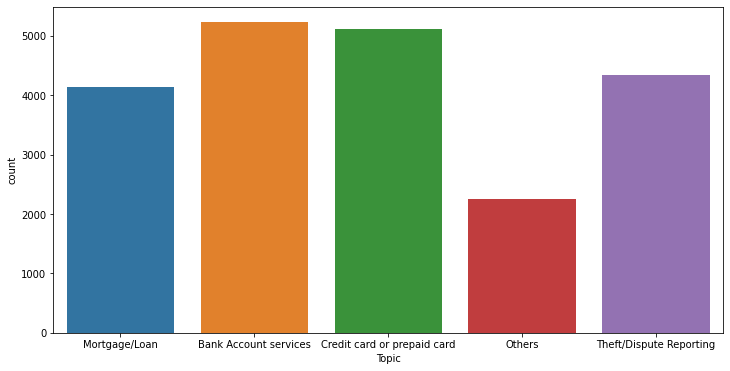

In [100]:
# Plot graph to check class imbalance
plt.figure(figsize=(12,6))
sns.countplot(x='Topic', data=df_clean)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [101]:
#Create the dictionary again of Topic names and Topics

Topic_names = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [102]:
df_clean

,complaint_text,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning xxxx xxxx appreciate help stop ch...,morning help write chase debt verification sta...,morning help write chase debt verification sta...,4
2,i upgraded my xxxx xxxx card in and was told b...,upgrade xxxx xxxx card tell agent upgrade anni...,agent upgrade anniversary date change agent in...,agent upgrade anniversary date change agent in...,0
10,chase card was reported on however fraudulent ...,chase card report fraudulent application submi...,chase card report application submit identity ...,chase card report application submit identity ...,1
11,on while trying to book a xxxx xxxx ticket i...,try book xxxx xxxx ticket come offer apply...,book ticket ticket reward card information off...,book ticket ticket reward card information off...,1
14,my grand son give me check for i deposit it in...,grand son check deposit chase account fund cle...,son deposit chase account account pay money sp...,son deposit chase account account pay money sp...,0
...,...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade offer multiple soli...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,wednesday xxxxxxxx call chas xxxx xxxx visa cr...,credit card provider ask claim purchase protec...,credit card provider ask claim purchase protec...,3
78310,i am not familiar with xxxx pay and did not un...,familiar xxxx pay understand great risk provid...,pay risk consumer app chase year trust banking...,pay risk consumer app chase year trust banking...,0
78311,i have had flawless credit for yrs ive had cha...,flawless credit yrs ve chase credit card cha...,credit chase credit card chase freedom problem...,credit chase credit card chase freedom problem...,2


In [103]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[['complaint_text','Topic']]

In [104]:
training_data

,complaint_text,Topic
1,good morning my name is xxxx xxxx and i apprec...,4
2,i upgraded my xxxx xxxx card in and was told b...,0
10,chase card was reported on however fraudulent ...,1
11,on while trying to book a xxxx xxxx ticket i...,1
14,my grand son give me check for i deposit it in...,0
...,...,...
78303,after being a chase card customer for well ove...,1
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,3
78310,i am not familiar with xxxx pay and did not un...,0
78311,i have had flawless credit for yrs ive had cha...,2


In [106]:
# x - y  split
X = training_data.complaint_text
y = training_data.Topic

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



